In [10]:
import numpy as np
import pandas as pd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt

# Customization del NoteBook
pd.set_option('display.width', 2000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Direccionamiento base del proyecto y archivos
rootProyecto = "./DatosProyecto/"
url_CSV = rootProyecto + "bank-additional.csv"
url_Excel = rootProyecto + "customer-details.xlsx"



In [11]:
# Procesamiento Hojas de cálculo EXCEL

# Determinamos las hojas del documento Excel a revisar
hojasExcel = pd.ExcelFile(url_Excel)

# Introducimos todas las hojas en una lista
contenedorHojas = []
for hoja in hojasExcel.sheet_names:
    contenedorHojas.append(pd.read_excel(url_Excel, sheet_name = hoja)) 

# Comprobamos que coincidan todas las columnas de las 3 hojas

columnasOk = True
for i in range(len(contenedorHojas)-1):
    if not contenedorHojas[i].columns.equals(contenedorHojas[i+1].columns):
        columnasOk = False

if columnasOk:
    db1 = pd.concat(contenedorHojas, ignore_index=True)
    print(db1.shape)


(43170, 7)


In [12]:
# Procesamiento Archivo CSV

#Abrimos archivo CSV y comprobamos longitud
db2 = pd.read_csv(url_CSV)
print(db2.shape)


(43000, 24)


In [13]:
# La idea es unir ambas tablas en una, por ello primero busco que columna utilizar para casar las tablas
print(db1.columns)
print(db2.columns)

Index(['Unnamed: 0', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'NumWebVisitsMonth', 'ID'], dtype='object')
Index(['Unnamed: 0', 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'date', 'latitude', 'longitude', 'id_'], dtype='object')


In [24]:
# He visto columnas incorrectas, por ejemplo:
#   - Columna "Unnamed: 0", se le cambia el nombre por position
#   - Columna "ID" e "id_": se cambian por un valor común, es la columna que usaré para casar ambas tablas
db1.rename(columns={"ID" : "id", "Unnamed: 0": "position"}, inplace=True)
db2.rename(columns={"id_": "id", "Unnamed: 0": "position"}, inplace=True)

#Aprovecho para poner en minúsculas todas las columnas y evitar así problemas case sensitive
db1.columns = db1.columns.str.lower().str.strip()
db2.columns = db2.columns.str.lower().str.strip()

print(db1.columns)
print(db2.columns)

Index(['position', 'income', 'kidhome', 'teenhome', 'dt_customer', 'numwebvisitsmonth', 'id'], dtype='object')
Index(['position', 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'date', 'latitude', 'longitude', 'id'], dtype='object')


In [15]:
# Comprobamos duplicados en ambas tablas
print(db1.duplicated().sum()) ## valores duplicados
print(db2.duplicated().sum()) ## valores duplicados

0
0


In [16]:
# Antes de hacer el merge, compruebo la longitud de ambas tablas
print(db1.shape)
print(db2.shape)

(43170, 7)
(43000, 24)


In [17]:
# Procedemos a unir las tablas
datosBanco = pd.merge(db1, db2, on="id", how="outer")

In [18]:
print(datosBanco.shape)

(43170, 30)


#### Analizamos 

##### Clientes Suscritos

In [19]:
# Cantidad  (y= 4844 ;; n=38156)
print(datosBanco['y'].value_counts())

y
no     38156
yes     4844
Name: count, dtype: int64


In [20]:
# De los clientes Suscritos:

# Primero: Filtramos por aquellos que están suscritos
clientesSuscritos = datosBanco[datosBanco["y"]=="yes"]

# Analizamos:
## Edad (de los 4844 clientes, 578 no han dado su edad):
print(clientesSuscritos["age"].count())
print(clientesSuscritos["age"].isnull().sum())
clientesSuscritosConEdad = clientesSuscritos[clientesSuscritos["age"]>0]

print(f"Cliente más Joven: {  (int)(clientesSuscritosConEdad["age"].min())}")    #17 años
print(f"Cliente más Mayor: {  (int)(clientesSuscritosConEdad["age"].max())}")    #98 años
print(f"Edad media: {         round(clientesSuscritosConEdad["age"].mean(),2)}") #40.88 años
print(f"Desviación Estandar: {round(clientesSuscritosConEdad["age"].std(),2)}")  #13.82 años
print(f"Varianza: {           round(clientesSuscritosConEdad["age"].var(),2)}")  #191.091


4266
578
Cliente más Joven: 17
Cliente más Mayor: 98
Edad media: 40.89
Desviación Estandar: 13.82
Varianza: 191.09


##### Edades

In [21]:
print(datosBanco["age"].unique())

[22. 56. 31. 38. 39. 43. 48. 36. 34. 44. 52. nan 46. 28. 53. 35. 33. 32.
 85. 51. 45. 59. 54. 24. 40. 60. 37. 29. 58. 30. 73. 55. 27. 25. 57. 47.
 42. 49. 83. 74. 26. 50. 21. 41. 18. 78. 61. 19. 76. 63. 98. 23. 65. 20.
 77. 64. 70. 62. 82. 81. 71. 88. 84. 68. 75. 67. 66. 79. 69. 86. 72. 80.
 92. 91. 95. 17. 94. 89. 87.]


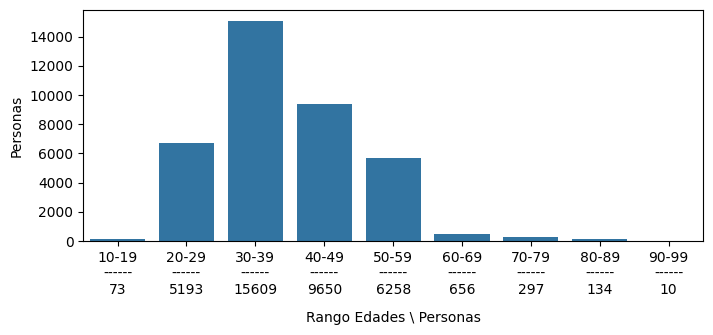

In [22]:
franjaEdades = range(10, 101, 10)  # 10-19, 20-29, ..., 90-99
#etiquetas = [f"{i}-{i+9}" for i in bins[:-1]]
etiquetas = []
#print(labels)
for i in franjaEdades[:-1]:
    etiquetas.append(f"{i}-{i+9}\n------\n{datosBanco[datosBanco['age'].between(i,i+9)]['id'].count()}")

conteos = pd.cut(datosBanco["age"], bins=franjaEdades, labels=etiquetas, right=True).value_counts().sort_index()

plt.figure(figsize=(8,3))
sns.barplot(x=conteos.index, y=conteos.values)
plt.ylabel("Personas")
plt.xlabel(f"Rango Edades \\ Personas", labelpad=10.0, loc="center")
plt.xticks(rotation=0)
plt.show()